# Simulate JEMRIS Phantom with MRZero
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

In [1]:
# check for dependencies
import importlib.util

packages = ['pytorch_finufft', 'git', 'pypulseq', 'MRzeroCore']
for package in packages:
    spec = importlib.util.find_spec(package)
    if (spec==None):
        print('Need to isntall package {}.'.format(package))
        if package=='pytorch_finufft':
            %pip install pytorch-finufft
        elif package=='git':
            %pip install gitpython
        elif package=='pypulseq':
            %pip install pypulseq
        elif package=='MRzeroCore':
            %pip install MRzeroCore

In [2]:
import os
import git

# clone qrage, if not present
if( not os.path.isdir('../qrage') ):
    print('qrage not installed, cloning ...')
    git.Git('../').clone('https://github.com/jumri-project/qrage.git')

In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, '../qrage/src/qrage')

In [4]:
import h5py
import torch

import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

In [5]:
# Set parameters
filepath = '.'

useJemrisSeq = False  # use JEMRIS sequence file
SimulateInversionEfficiency = False  # simulate inversion efficiency

phantom_slices = 12
phantom_slices_thickness = 5e-3 # m

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=20e-6,
    grad_raster_time=50*1e-6
)

## 1. Load H5 Sample File and create MRZero sampe from it

In [6]:
# Read JEMRIS sample file
# filename = 'SheppLogan.h5'                                                # Standard SheppLogan Phanrom
filename = 'sample_DoubleSphere_R75_DX1p0_T1_1000_2000_T2_25_30.h5'         # Concenrtic spheres

fullfilename = os.path.join(filepath, filename)

# open h5 file for reading 
f = h5py.File(fullfilename, "r")

# Get the HDF5 group 'sample'
group = f['sample']

# read group data
data = group['data'][()]
offset = group['offset'][()]
resolution = group['resolution'][()]

# close file
f.close()

In [7]:
# converst JEMRIS sample data into torch tensors
T1 = np.divide( 1, data[:,:,1], out=np.zeros_like(data[:,:,1], dtype=float), where=data[:,:,1]!=0)
T2 = np.divide( 1, data[:,:,2], out=np.zeros_like(data[:,:,2], dtype=float), where=data[:,:,2]!=0)

PD = torch.tensor( np.transpose(data[:,:,0]) )
T1 = torch.tensor( np.transpose(T1 / 1e3) )      # conversion from ms to s required
T2 = torch.tensor( np.transpose(T2 / 1e3) )      # conversion from ms to s required
DB = torch.tensor( np.transpose(data[:,:,4]) )

In [8]:
# add axis and slices to the phantom
PD = PD[:,:,None]
T1 = T1[:,:,None]
T2 = T2[:,:,None]
DB = DB[:,:,None]

if phantom_slices > 1:
    PD = PD.repeat(1,1,phantom_slices)
    T1 = T1.repeat(1,1,phantom_slices)
    T2 = T2.repeat(1,1,phantom_slices)
    DB = DB.repeat(1,1,phantom_slices)

In [9]:
# create missing entries
T2dash = torch.ones_like(PD) * 0.0125     # 1/T2prime = 1/T2star - 1/T2, here T2=45ms, T2=33ms for GM from literature
D = torch.zeros_like(PD)
B1 = torch.zeros_like(PD)
# B1[PD!=0] = 1.0
B1 = B1[None, :, :, :]                  # needs first axis to be number of coil elements
coil_sens = torch.ones_like(B1)


In [10]:
# create the phantom
size = torch.tensor( (resolution[0,0]*PD.shape[0]/1000, resolution[1,0]*PD.shape[1]/1000, phantom_slices*phantom_slices_thickness) )

print(size)

# TEST
# size[2] *= 2
# T1[T1!=0] = 0.5
# T2[T2!=0] = 0.03

phantom = mr0.VoxelGridPhantom(PD=PD, T1=T1, T2=T2, T2dash=T2dash, D=D, B0=DB, B1=B1, coil_sens=coil_sens, size=size)

tensor([0.1500, 0.1500, 0.0600], dtype=torch.float64)


VoxelGridPhantom
size = tensor([0.1500, 0.1500, 0.0600])
Plotting slice 6 / 12


/opt/conda/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


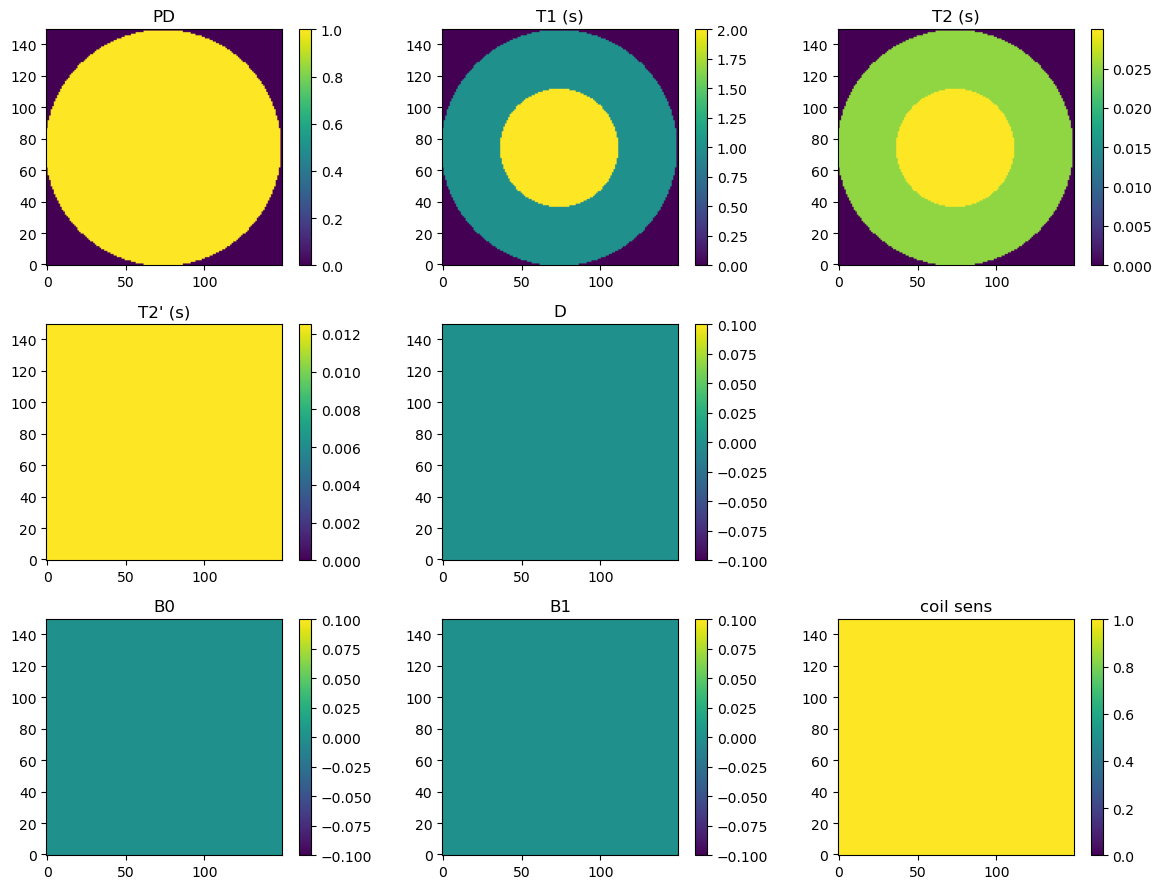

In [11]:
phantom.plot()

In [12]:
data = phantom.build()

## Alternate phantom

In [13]:
# # Uncomment the following lines to use the default brain phantom

# sz = [128, 128]
# obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat', size=torch.tensor([0.2, 0.2, 0.001]))
# obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# # Manipulate loaded data
# obj_p.D *= 0
# obj_p.B0 *= 0
# obj_p.plot()

# # Convert Phantom into simulation data
# obj_p = obj_p.build()

# data = obj_p

## 6. Create MEGE sequence and simulate

In [14]:
import sys
import platform
from types import SimpleNamespace

In [15]:
from sequence.mege import MEGE

### Create Sequence

In [16]:
seq_write = True
seq_plot = True
seq_calculate_gradient_spectrum = True
seq_check_timing = True
seq_test_report = True
seq_filename = os.path.join (filepath, 'mege.seq')

In [17]:
seq = pp.Sequence()

num_spokes = 32
num_echoes = 9
num_partitions_per_block = 12
num_autocalibration_lines = 32
acceleration_factor = 2
image_slice_thickness = 2 # mm
fov = np.array([256, 256, num_partitions_per_block*image_slice_thickness]) * 1e-3
matrix_size = np.array([256, 256, num_partitions_per_block])
readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [18]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "MEGE")

In [19]:
mege = MEGE(
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    debug=False,
    system=system
)

/workspaces/juart-dev/notebooks/../qrage/src/qrage/sequence/readout.py:95: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  pp.make_sinc_pulse(
/workspaces/juart-dev/notebooks/../qrage/src/qrage/sequence/readout.py:130: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  self.adc = pp.make_adc(


In [20]:
mege.run(seq)

In [21]:
mege.get_timing(seq)
print(
    "dTE %s ms" % np.round(mege.dTE, decimals=1),
    "TE0 %s ms" % np.round(mege.TE0, decimals=1),
)

dTE 3.2 ms TE0 3.2 ms


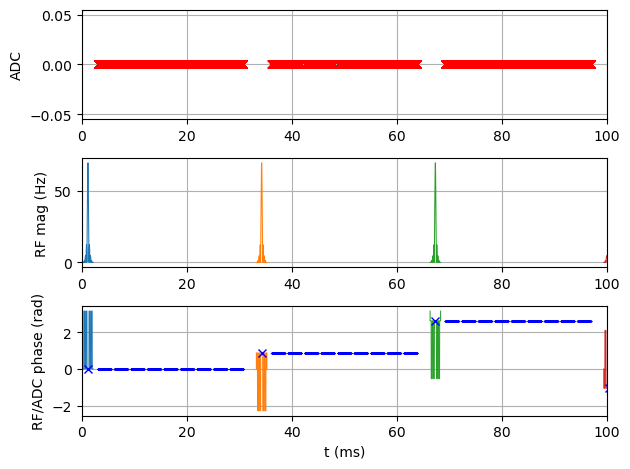

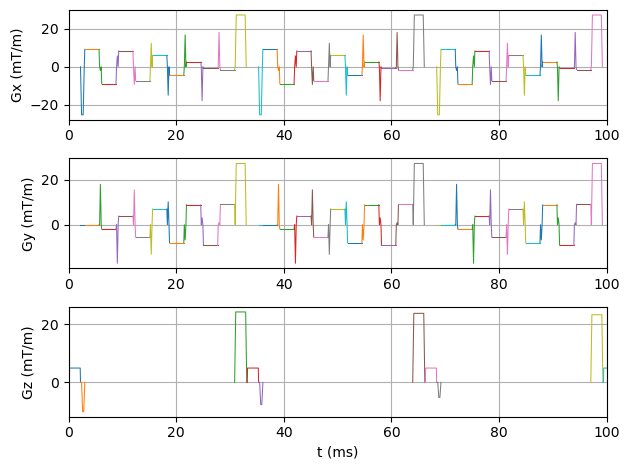

In [22]:
if seq_plot:
    seq.plot(time_range=[0, 0.1], grad_disp="mT/m", time_disp="ms", show_blocks=False)

Resonance frequencies of gradients (x, y, z) are:  [160.         160.          86.66666667]


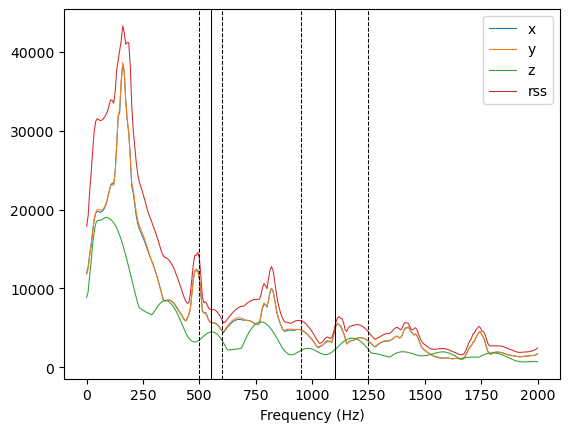

In [23]:
if seq_calculate_gradient_spectrum:
    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( 
        acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    res_freqs = freq[np.argmax(spects, axis=1)]
    print("Resonance frequencies of gradients (x, y, z) are: ", res_freqs)

In [24]:
if seq_check_timing:
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed")
    else:
        print("Timing check failed")
        [print(e) for e in error_report]

Timing check passed


In [25]:
if seq_test_report:
    rep = seq.test_report()
    print(rep)

Number of blocks: 7680
Number of events:
RF:    384
Gx:   7296
Gy:   7296
Gz:   1152
ADC:   3456
Delay:      0
Sequence duration: 12.710400 s
TE: 0.006325 s
TR: 0.033100 s
Flip angle: 5.00 deg
Unique k-space positions (aka cols, rows, etc.): 71790 71732 12 
Dimensions: 3
Spatial resolution: 0.98 mm
Spatial resolution: 0.98 mm
Spatial resolution: 2.00 mm
Repetitions/slices/contrasts: 1.0; range: [(np.float64(1.0), np.float64(288.0))]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Max gradient: 1161318 1161318 1169970 Hz/m == 27.28 27.28 27.48 mT/m
Max slew rate: 5806587838 5806587838 5849847561 Hz/m/s == 136.38 136.38 137.40 T/m/s
Max absolute gradient: 2016469 Hz/m == 47.36 mT/m
Max absolute slew rate: 1.00823e+10 Hz/m/s == 236.81 T/m/s
Event timing check passed successfully



In [26]:
if seq_write:
    seq.write(seq_filename)

In [27]:
# Store sequence information for later processing in h5 file
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'mege_info.h5'), 'w') as f:
    dset = f.create_dataset('num_spokes', data=num_spokes)
    dset = f.create_dataset('num_echoes', data=num_echoes)
    dset = f.create_dataset('num_partitions_per_block', data=num_partitions_per_block)
    dset = f.create_dataset('num_autocalibration_lines', data=num_autocalibration_lines)
    dset = f.create_dataset('acceleration_factor', data=acceleration_factor)
    dset = f.create_dataset('matrix_size', data=matrix_size)
    dset = f.create_dataset('readout_bandwidth', data=readout_bandwidth)
    
    dset = f.create_dataset('dTE', data=mege.dTE)
    dset = f.create_dataset('TE0', data=mege.TE0)
    # dset = f.create_dataset('TR', data=mege.TR)

    dset = f.create_dataset('FoV', data=fov)


### Simulate

In [28]:
seq0 = mr0.Sequence.import_file(seq_filename)
print(seq_filename)

# Test is gradient scaling is correct
# for rep in seq0:
#     rep.gradm[:, 0] /= 0.2
#     rep.gradm[:, 1] /= 0.2
#     rep.gradm[:, 2] /= 0.2

# seq0.plot_kspace_trajectory()

./mege.seq


In [29]:
# Very precise simulation
# graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
# signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

# Average precision
# graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
# signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

# low precision simulation
graph = mr0.compute_graph(seq0, data, 200, 1e-4)
if torch.cuda.is_available(): 
    print('>>>> Using CUDA for simulation <<<<.')
    signal = mr0.execute_graph(graph, seq0.cuda(), data.cuda(), 0.01, 0.01).cpu()
else:
    signal = mr0.execute_graph(graph, seq0, data, 0.01, 0.01)

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.005488333 s
Compute Graph
Computing Graph: 0.027349085 s
Analyze Graph
Analyzing Graph: 0.000064375 s
Converting Rust -> Python: 0.000174167 s
<<<< Rust <<<<
Calculating repetition 384 / 384 - done


In [30]:
# Read sequence with pypulseq to get information on acquisition scheme
seq = pp.Sequence()
seq.read(seq_filename)

### Convert into ISMRMRD format (without full header)

In [31]:
# Tool from Felix Landmeyer to create ISMRMRD dataset from MRZERO simulation
import seqtraj_to_mrd

In [32]:
# Set required definitions
NCol = matrix_size[1]
seq.set_definition('MaxAdcSegmentLength',NCol)

# TEST
# seq.set_definition('MaxAdcSegmentLength',NCol/2)

In [33]:
# save file
seqtraj_to_mrd.mr0_to_mrd(seq, signal, os.path.join('..','LocalData', 'Simulations', 'mege.h5'))

### Create MRD Dataset ###


/workspaces/juart-dev/notebooks/seqtraj_to_mrd.py:104: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  acquisition.data[:] = s.T
